In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


(Mounted our drive)

In [ ]:
!pip install pmdarima
!pip install matplotlib
!pip install nb-black

Installing Packages for ARIMA approach

In [7]:
from pmdarima.arima import auto_arima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns


In [144]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv("/content/drive/MyDrive/SoC Files/GOOG_train.csv", index_col='Date', parse_dates=True, date_parser=dateparse).fillna(0)
df=df.dropna()
print('Shape of data',df.shape)
df.head()
df
print(df.head())
df.isnull()

Shape of data (1258, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-06-10  719.469971  725.890015  716.429993  719.409973  719.409973   
2016-06-13  716.510010  725.440002  716.510010  718.359985  718.359985   
2016-06-14  716.479980  722.469971  713.119995  718.270020  718.270020   
2016-06-15  719.000000  722.979980  717.309998  718.919983  718.919983   
2016-06-16  714.909973  716.650024  703.260010  710.359985  710.359985   

             Volume  
Date                 
2016-06-10  1216400  
2016-06-13  1258900  
2016-06-14  1306100  
2016-06-15  1214500  
2016-06-16  1982500  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-10,False,False,False,False,False,False
2016-06-13,False,False,False,False,False,False
2016-06-14,False,False,False,False,False,False
2016-06-15,False,False,False,False,False,False
2016-06-16,False,False,False,False,False,False
...,...,...,...,...,...,...
2021-06-03,False,False,False,False,False,False
2021-06-04,False,False,False,False,False,False
2021-06-07,False,False,False,False,False,False


In [46]:
#df = df[["Close"]].copy()
#df.describe()

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [47]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 1.9368159937737082
p-value: 0.9985850027950328


In [48]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df['Close'])

1. ADF :  1.9368159937737082
2. P-Value :  0.9985850027950328
3. Num Of Lags :  22
4. Num Of Observations Used For ADF Regression: 1235
5. Critical Values :
	 1% :  -3.4356560275160835
	 5% :  -2.8638831211270817
	 10% :  -2.568017509711682


In [49]:
from statsmodels.graphics.tsaplots import plot_acf

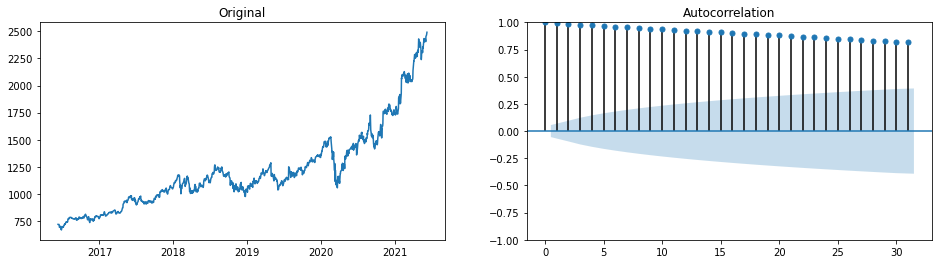

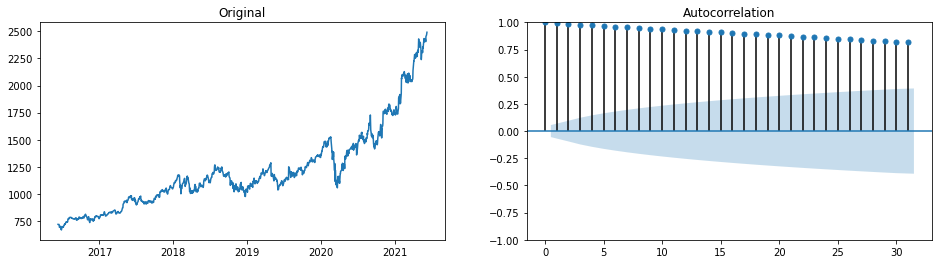

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2)

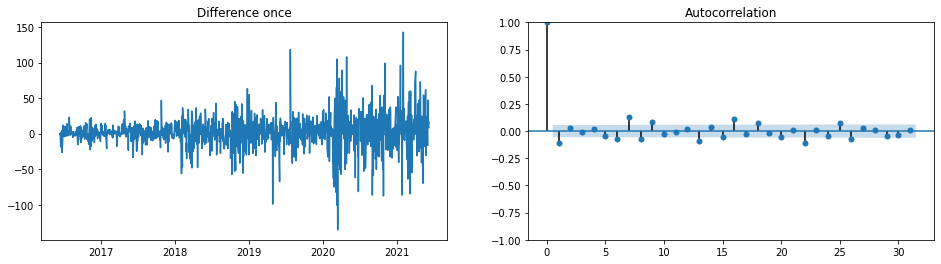

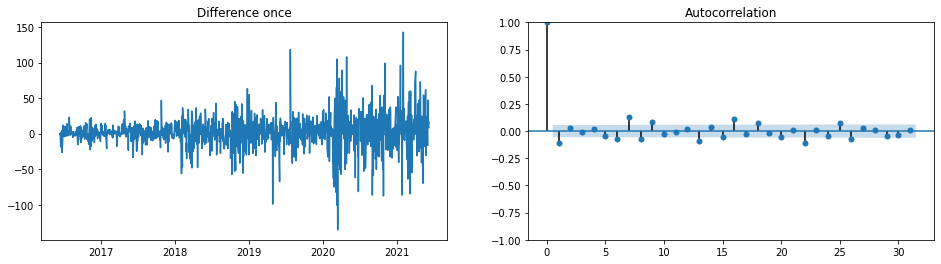

In [12]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

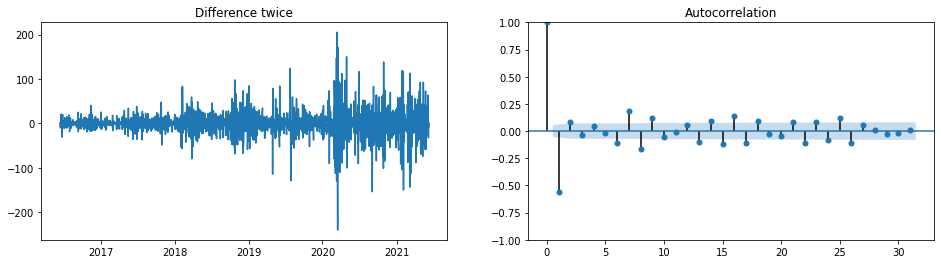

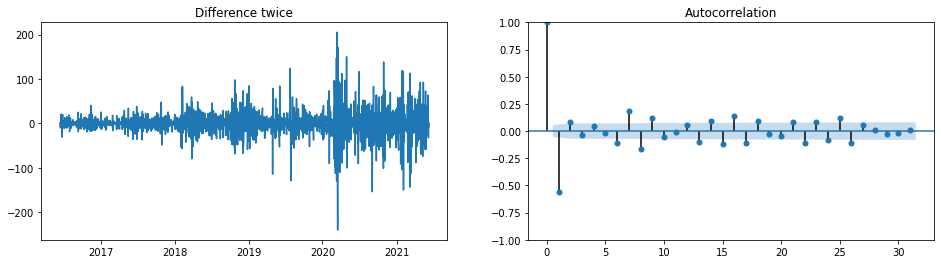

In [13]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

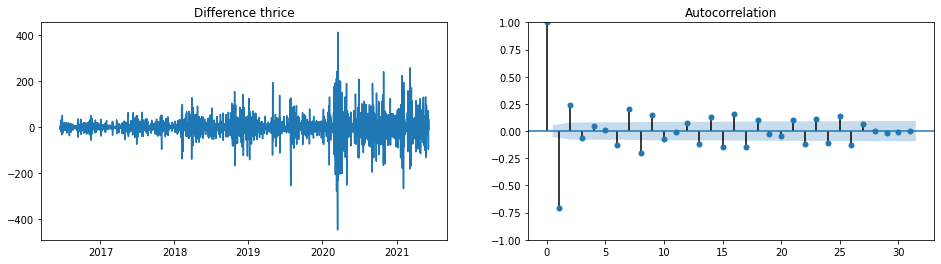

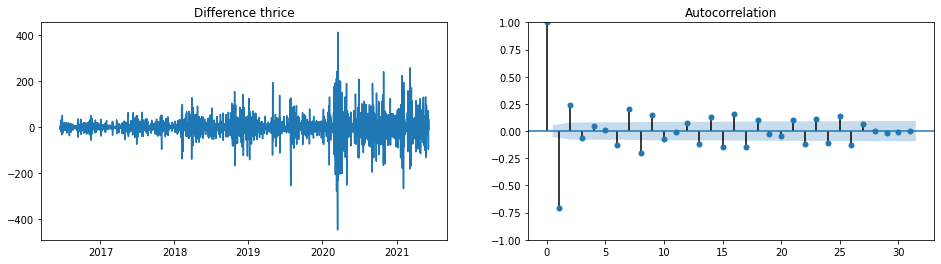

In [14]:
diff = df.Close.diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference thrice")
plot_acf(diff, ax=ax2)

In [15]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

In [16]:
ndiffs(df.Close, test="adf")

1

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


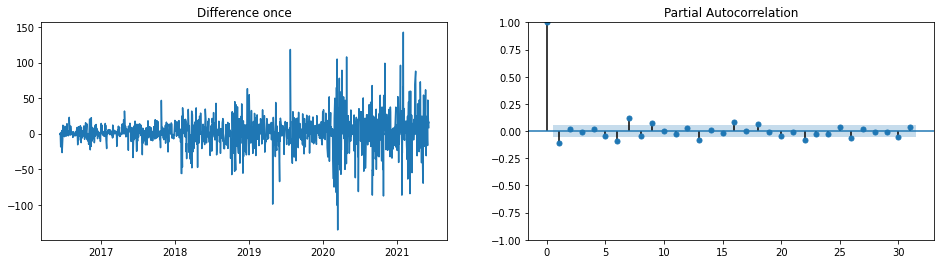

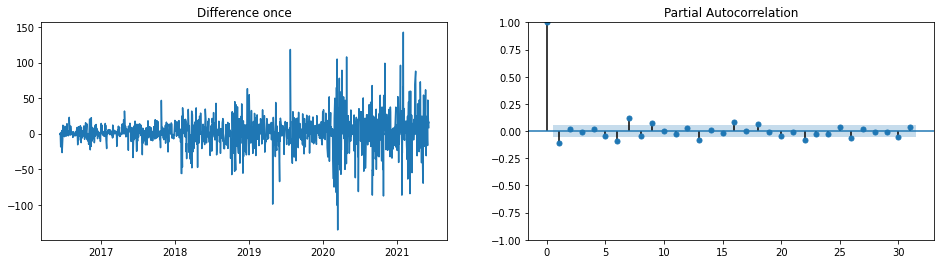

In [18]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 1 is significant as it's above the significance line.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

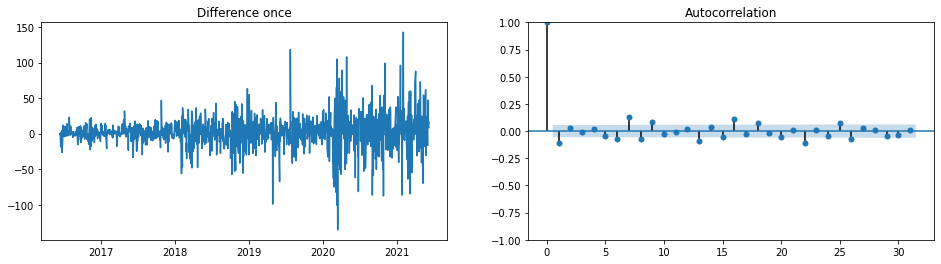

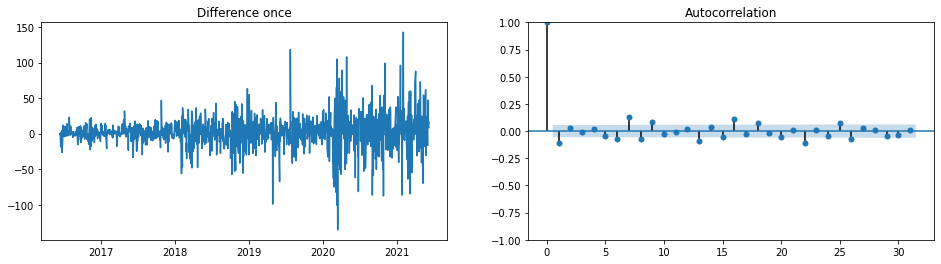

In [19]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

In [23]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Close'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11344.912, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11352.162, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11339.446, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11340.105, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11355.272, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11341.026, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11340.960, Time=1.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11342.904, Time=1.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=11343.758, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 6.100 seconds


In [162]:
print(df.shape)
train=df.iloc[0:1228]
test=df.iloc[1228:1258]
print(train.shape,test.shape)

(1258, 6)
(1228, 6) (30, 6)


In [76]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Close'],order=(1,1,0))
model=model.fit()
model.summary()

#import statsmodels.api as sm
#model = sm.tsa.arima.ARIMA(df.Close, order=(1, 1, 4))
#result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1228
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5511.339
Date:                Tue, 19 Jul 2022   AIC                          11026.678
Time:                        09:35:20   BIC                          11036.903
Sample:                             0   HQIC                         11030.525
                               - 1228                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1167      0.016     -7.095      0.000      -0.149      -0.084
sigma2       467.0141      8.958     52.135      0.000     449.457     484.571
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2494.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              11.66   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

DatetimeIndex(['2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',
               '2021-05-14', '2021-05-15', '2021-05-16', '2021-05-17',
               '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
               '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
               '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
               '2021-05-30', '2021-05-31', '2021-06-01', '2021-06-02',
               '2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06',
               '2021-06-07', '2021-06-08'],
              dtype='datetime64[ns]', freq='D')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


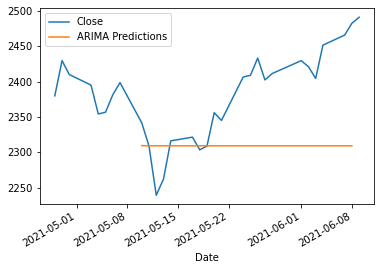

In [168]:
start=len(train)
end=len(train)+len(test)-1
#pred.plot(legend=True)

#start=len(train)
#end=len(train)+len(test)-1
#pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
#pred.plot(legend=True)
test['Close'].plot(legend=True)

index_future_dates=pd.date_range(start='2021-05-10',end='2021-06-08')
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
print(index_future_dates)
pred.index=index_future_dates
pred.plot(legend=True)
#print(pred)

(array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.0118487],
        [0.       , 0.0118487, 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.0118487, 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.0118487, 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.0118487, 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.0118487, 0.       , ..., 0.       , 0.       ,
         0.       ]]),
 array([-124.56448675,  -40.16704077,   44.2304052 ,  128.62785118,
         213.02529715,  297.42274313,  381.8201891 ,  466.21763508,
         550.61508105,  635.01252703,  719.409973  ]),
 <a list of 1258 Lists of Patches objects>)

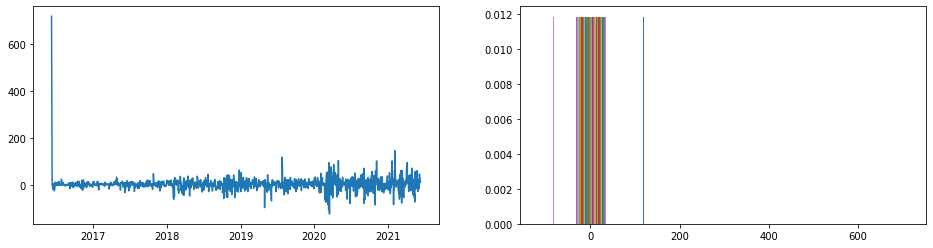

In [25]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

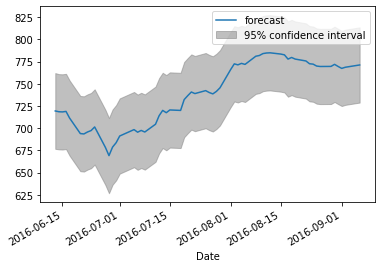

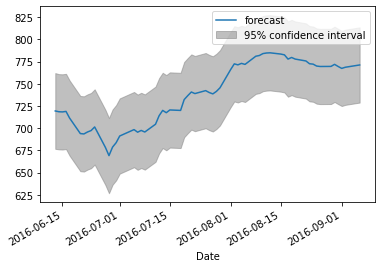

In [53]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model,
    start=1,
    end=60,
    dynamic=False,
)

In [92]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Close'].mean()
rmse=sqrt(mean_squared_error(pred,test['Close']))
print(rmse)


94.03515161983164


In [148]:
df2 = pd.read_csv("/content/drive/MyDrive/SoC Files/GOOG_test.csv", index_col='Date', parse_dates=True)
df2=df2.dropna()
print('Shape of data',df2.shape)
df2.head()
df2
print(df2.head())
df2.isnull()
model2=ARIMA(df2['Close'],order=(1,1,0))
model2=model2.fit()
df2.tail()

Shape of data (253, 6)
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2021-06-10  2494.010010  2523.260010  2494.000000  2521.600098  2521.600098   
2021-06-11  2524.919922  2526.989990  2498.290039  2513.929932  2513.929932   
2021-06-14  2513.389893  2528.229980  2500.939941  2527.040039  2527.040039   
2021-06-15  2530.439941  2537.239990  2512.969971  2520.659912  2520.659912   
2021-06-16  2524.949951  2530.469971  2482.999023  2513.929932  2513.929932   

             Volume  
Date                 
2021-06-10  1561700  
2021-06-11  1262000  
2021-06-14  1127500  
2021-06-15  1109100  
2021-06-16  1315800  


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-03,2319.850098,2327.290039,2273.360107,2291.280029,2291.280029,1252600
2022-06-06,2334.850098,2387.969971,2330.565918,2340.209961,2340.209961,1189300
2022-06-07,2312.959961,2354.972900,2302.510010,2344.590088,2344.590088,1320700
2022-06-08,2337.530029,2372.919922,2333.935059,2344.760010,2344.760010,1127200
2022-06-09,2326.830078,2367.000000,2297.340088,2298.360107,2298.360107,1157100


DatetimeIndex(['2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13',
               '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-19',
               ...
               '2022-05-31', '2022-06-01', '2022-06-02', '2022-06-03',
               '2022-06-04', '2022-06-05', '2022-06-06', '2022-06-07',
               '2022-06-08', '2022-06-09'],
              dtype='datetime64[ns]', length=365, freq='D')


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


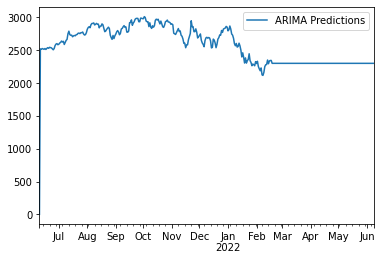

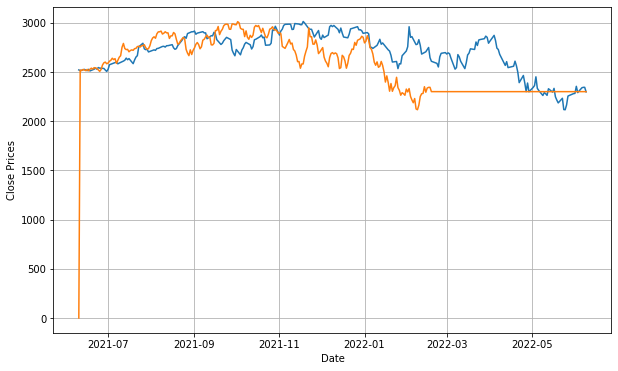

In [170]:
index_future_dates=pd.date_range(start='2021-06-10',end='2022-06-09')
print(index_future_dates)
predi=model2.predict(start=0,end=len(df2)+111,typ='levels').rename('ARIMA Predictions')
predi.index=index_future_dates
#print(pred)
predi.plot(legend=True)
#df2['Close'].plot(legend=True)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df2['Close'])
plt.plot(predi)
plt.title('')
plt.show()